In [42]:
import pandas as pd
import numpy as np

In [43]:
# Datensatz einlesen
original_dms_data = pd.read_csv('/Users/liza/Documents/Bioinfo Project/DMS_data/AAAA_GFP_dms_data_original_komplett.csv')
# split first column of df into multiple columns
original_dms_data_col = original_dms_data
only_mutants = original_dms_data["mutant"].to_frame()
original_dms_data_col[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15']] = original_dms_data_col['mutant'].str.split(':', 15, expand=True)

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/1825307730.py:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  original_dms_data_col[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15']] = original_dms_data_col['mutant'].str.split(':', 15, expand=True)


In [44]:
# zählen wieviele Mutationen jede Sequenz hat
list_mut_count_in_progress = []
for i in range(len(original_dms_data['mutant'])):
    list_mut_count_in_progress.append(original_dms_data['mutant'].iloc[i].count(':'))
list_mut_count_prae = np.array(list_mut_count_in_progress)
list_mut_count = (list_mut_count_prae + 1)
df_mutation_counts = pd.DataFrame(list_mut_count)

In [45]:
#zusammenfügen
working_dataframe_prae = pd.concat([original_dms_data_col, df_mutation_counts], axis="columns")
#alle Spalten löschen die stören
working_dataframe = working_dataframe_prae.drop(['mutant', 'mutated_sequence', 'DMS_score_bin'], axis=1)
working_dataframe.rename(columns={working_dataframe.columns[16]: 'mut_count'}, inplace=True)

nur_fscore_mut_count = working_dataframe.loc[:, ["DMS_score", "mut_count"]]

In [46]:
#alle möglichen Mutationen rausschreiben in den Spalten
#all_possible_mutations

from pandas import unique
working_dataframe_only_ms = working_dataframe.loc[:, ["m1", "m2", "m3", 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15']]
all_possible_mutations = working_dataframe_only_ms.values.flatten().tolist()
all_possible_mutations = list(set(all_possible_mutations))
#hat einen none Wert, weil der auch ein Wert in der Liste ist -> wegmachen
while None in all_possible_mutations:
    all_possible_mutations.remove(None)
only_mutants_list = only_mutants['mutant']


In [47]:
#zusammenfügen
working_dataframe_prae = pd.concat([original_dms_data_col, df_mutation_counts], axis="columns")
#alle Spalten löschen die stören
working_dataframe = working_dataframe_prae.drop(['mutant', 'mutated_sequence', 'DMS_score_bin'], axis=1)
working_dataframe.rename(columns={working_dataframe.columns[16]: 'mut_count'}, inplace=True)


In [48]:
##kreuztabelle ob all_possible_mutations in den Mutanten existieren

list_of_dfs = []
# For-Loop zum Erstellen und Hinzufügen eines neuen Columns in jedem Durchlauf
for i in all_possible_mutations:
    new_column_name = f'{i}'
    new_column_values = [only_mutants_list.str.contains(i, regex= False)]
    new_df = pd.DataFrame({new_column_name: new_column_values})
    new_df_exploded = new_df.explode(new_column_name)
    list_of_dfs.append(new_df_exploded)

# Verketten der DataFrames in der Liste
result_how_often = pd.concat(list_of_dfs, axis=1)
result_how_often = result_how_often.reset_index(drop=True)

## result_how_often.to_csv('dataframe_mutanten_Mutationen.csv', index=True)

In [49]:
# dataframe aus original machen der nur mutcount und fscore hat
count_fscore_frame = working_dataframe[['DMS_score', 'mut_count']]

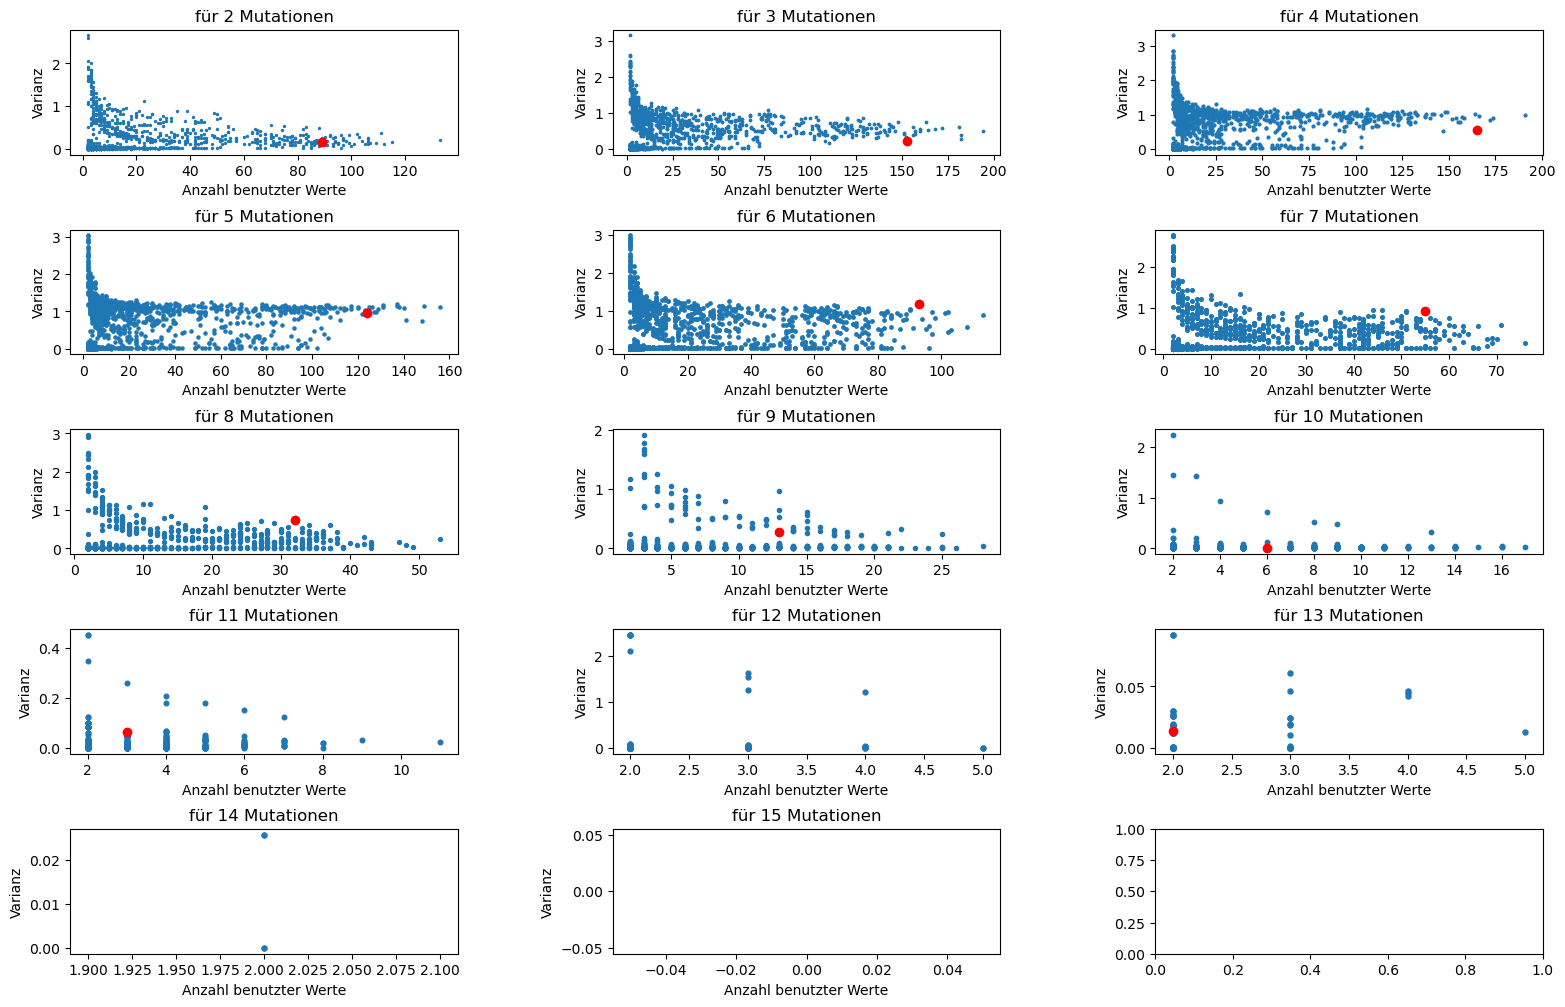

In [50]:
#plots für jeden mutcount varianz gegen how_many

import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(19, 12))  # Abbildung und Achsenobjekte erstellen
plt.subplots_adjust(wspace=0.4, hspace=0.6)

for j, ax in zip(range(2, 16), axes.flatten()):
    variance_per_mutant_list = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        varianz_mut = fscore_mut.var()
        variance_per_mutant_list.append(varianz_mut)

    variance_per_mutant_series = pd.Series(variance_per_mutant_list, index=all_possible_mutations)
    variance_per_mutant_df = variance_per_mutant_series.to_frame()


#rausfinden wie viele Daten wir jeweils haben zum berechnen
    how_many_for_variance = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        wie_viel_jeweils = len(fscore_mut)
        how_many_for_variance.append(wie_viel_jeweils)

    how_many_for_variance = pd.Series(how_many_for_variance, index=all_possible_mutations)
    how_many_for_variance_df = how_many_for_variance.to_frame()


    how_many_AND_variance_df = pd.concat([how_many_for_variance_df, variance_per_mutant_df], axis = 1)
    how_many_AND_variance_df.columns = ['Anzahl benutzter Werte', 'Varianz']
    how_many_AND_variance_df = how_many_AND_variance_df.dropna()

#scatter plot erstellen, mit benennungen
    ax.scatter(how_many_AND_variance_df['Anzahl benutzter Werte'],how_many_AND_variance_df['Varianz'], s = j )
    ax.set_xlabel('Anzahl benutzter Werte')
    ax.set_ylabel('Varianz')

    if "V163A" in how_many_AND_variance_df.index:
        ax.scatter(how_many_AND_variance_df['Anzahl benutzter Werte']['V163A'],how_many_AND_variance_df['Varianz']['V163A'], c='red')
    ax.set_title(f'für {j} Mutationen')



VORBEREITUNG RANKINGS: Definitionen etc


In [51]:
#Varianzen mitteln für jede Mutation, über die Mutationscounts hinweg
frame_zum_mitteln_variance = pd.DataFrame(index = all_possible_mutations)
variance_per_mutant_count_list = []

# ACHTUNG: es werden nur counts von 2 bis 7 einbezogen weil die mit mehr sowieso "kaputt" sind!!!
for j, ax in zip(range(2, 8), axes.flatten()):
    variance_per_mutant_list = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        varianz_mut = fscore_mut.var()  #die varianz je mutation je anzahl
        variance_per_mutant_list.append(varianz_mut) #liste der Varianzen ALLER Mutationen je anzahl

    variance_per_mutant_df = pd.DataFrame(variance_per_mutant_list, index=all_possible_mutations)
    variance_per_mutant_count_list.append(variance_per_mutant_df)
variance_per_mutant_count_df = pd.concat(variance_per_mutant_count_list, axis=1)
variance_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)

# Varianz je Mutation je Mutationanzahl
variance_per_mutant_count_df
# dataframe mit allen varianzen (Zellen) pro alle mutationen (rows) pro alle counts (columns)
mean_variances_per_mutations = pd.DataFrame(variance_per_mutant_count_df.mean(axis=1, skipna=True), columns=['Mean'])


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/1098898036.py:18: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  variance_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)


In [52]:
#dataframe with the mean fscores of each mutation count
mean_fitness_scores = pd.DataFrame(index = range(2,16), columns = ["mean_fitness_score"])
for i in range(2,16):
    fscore_mutcount_mean = count_fscore_frame["DMS_score"].loc[count_fscore_frame["mut_count"] == i].mean()
    mean_fitness_scores.loc[i, "mean_fitness_score"] = fscore_mutcount_mean
print(mean_fitness_scores)

   mean_fitness_score
2            3.345506
3            3.012676
4            2.554671
5            2.110624
6            1.798413
7            1.599889
8            1.513703
9            1.440711
10           1.430934
11           1.394099
12           1.465141
13           1.403067
14           1.414609
15           1.326549


für was anderes (hier unwichtig)
--> 384 von 1810 sind gleich 0 weil die Mutation nur einmal pro mutcount vorkommt, müssen bei den rankings nicht beachtet werden, zu wenig Werte

In [53]:
how_many_per_mutant_count_list = []

for j, ax in zip(range(2, 8), axes.flatten()):
    how_many_for_variance = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        wie_viel_jeweils = len(fscore_mut)
        how_many_for_variance.append(wie_viel_jeweils)

    how_many_per_mutant_df = pd.DataFrame(how_many_for_variance, index=all_possible_mutations)
    how_many_per_mutant_count_list.append(how_many_per_mutant_df)
how_many_per_mutant_count_df = pd.concat(how_many_per_mutant_count_list, axis=1)
how_many_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)

mean_how_many_per_mutations = pd.DataFrame(how_many_per_mutant_count_df.mean(axis=1, skipna=True), columns=['Mean'])


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/2598593114.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  how_many_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)


In [54]:
combined_means_variance_how_many = pd.concat([mean_variances_per_mutations, mean_how_many_per_mutations], axis=1)
combined_means_variance_how_many.columns = ['mean_variances_per_mutations', 'mean_how_many_per_mutations']

----------------RANKING 0 weighted: only by Variance from the fscores
-> no ranking 0 because there is no difference to the unweighted ranking 0

same with: RANKING 1 and 1a



----------------RANKING 2 weighted: nur nach fscore_mean Differenz

In [55]:
# Create an empty dataframe to store the results
mean_for_differences_with_neu = pd.DataFrame(index=all_possible_mutations, columns=range(2, 16))

for mutation in all_possible_mutations:
    for mutation_count in range(2, 16):

        index_when_mut_present_weighted = result_how_often.loc[result_how_often[mutation] == True].index

        only_rows_with_mut_weighted = nur_fscore_mut_count[(nur_fscore_mut_count['mut_count'] == mutation_count) & (nur_fscore_mut_count.index.isin(index_when_mut_present_weighted))]

        # Calculate the mean of fitness score for the filtered rows
        mean_fitness_with_mut_score = only_rows_with_mut_weighted['DMS_score'].mean()

        # Store the mean fitness score in the result dataframe
        mean_for_differences_with_neu.loc[mutation, mutation_count] = mean_fitness_with_mut_score


In [56]:
weighted_means_WITH = pd.Series(index=mean_for_differences_with_neu.index)

for mutation in mean_for_differences_with_neu.index:
    row_WITH = mean_for_differences_with_neu.loc[mutation]
    non_nan_values_WITH = row_WITH.dropna()

    if len(non_nan_values_WITH) > 0:
        non_nan_weights_WITH = mean_fitness_scores.loc[non_nan_values_WITH.index]['mean_fitness_score']
        weighted_means_WITH[mutation] = np.average(non_nan_values_WITH, weights=non_nan_weights_WITH)

weighted_means_df_WITH = pd.DataFrame({'Weighted Mean WITH': weighted_means_WITH})

print(weighted_means_df_WITH)


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/3591349614.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  weighted_means_WITH = pd.Series(index=mean_for_differences_with_neu.index)


       Weighted Mean WITH
F27H             1.556449
M88A             3.557818
L60H             1.441257
G67V             1.412200
H25L             2.223739
...                   ...
Y74C             1.495502
T9P              2.417862
A110S            2.529803
G160S            2.558431
D180V            2.093056

[1810 rows x 1 columns]


In [57]:
# Create an empty dataframe to store the results
mean_for_differences_withOUT_neu = pd.DataFrame(index=all_possible_mutations, columns=range(2, 16))

for mutation in all_possible_mutations:
    for mutation_count in range(2, 16):

        index_when_mut_NOT_present_weighted = result_how_often.loc[result_how_often[mutation] == False].index

        only_rows_withOUT_mut_weighted = nur_fscore_mut_count[(nur_fscore_mut_count['mut_count'] == mutation_count) & (nur_fscore_mut_count.index.isin(index_when_mut_NOT_present_weighted))]

        # Calculate the mean of fitness score for the filtered rows
        mean_fitness_withOUT_mut_score = only_rows_withOUT_mut_weighted['DMS_score'].mean()

        # Store the mean fitness score in the result dataframe
        mean_for_differences_withOUT_neu.loc[mutation, mutation_count] = mean_fitness_withOUT_mut_score


In [58]:
weighted_means_WITHOUT = pd.Series(index=mean_for_differences_withOUT_neu.index)

for mutation in mean_for_differences_withOUT_neu.index:
    row_WITHOUT = mean_for_differences_withOUT_neu.loc[mutation]
    non_nan_values_WITHOUT = row_WITHOUT.dropna()

    if len(non_nan_values_WITHOUT) > 0:
        non_nan_weights_WITHOUT = mean_fitness_scores.loc[non_nan_values_WITHOUT.index]['mean_fitness_score']
        weighted_means_WITHOUT[mutation] = np.average(non_nan_values_WITHOUT, weights=non_nan_weights_WITHOUT)

weighted_means_df_WITHOUT = pd.DataFrame({'Weighted Mean WITHOUT': weighted_means_WITHOUT})


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/2325641272.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  weighted_means_WITHOUT = pd.Series(index=mean_for_differences_withOUT_neu.index)


       Weighted Mean WITHOUT
F27H                2.064192
M88A                2.064167
L60H                2.065390
G67V                2.064289
H25L                2.060837
...                      ...
Y74C                2.066445
T9P                 2.065467
A110S               2.064220
G160S               2.063974
D180V               2.064829

[1810 rows x 1 columns]


In [59]:
all_differences_means_weighted = weighted_means_df_WITH['Weighted Mean WITH'] - weighted_means_df_WITHOUT['Weighted Mean WITHOUT']
all_differences_means_weighted = all_differences_means_weighted.to_frame()

In [115]:
#print(all_differences_means_weighted)

In [61]:
#VORBEREITUNG copy&paste
list_wie_oft_mut = []
for j in all_possible_mutations:
    matching_indexes = result_how_often.loc[result_how_often[j] == True].index
    wie_oft = len(matching_indexes)
    list_wie_oft_mut.append(wie_oft)
df_wie_oft_muts_insg = pd.DataFrame(list_wie_oft_mut, index=all_possible_mutations)
df_wie_oft_muts_insg

,0
F27H,1
M88A,3
L60H,140
G67V,14
H25L,298
...,...
Y74C,256
T9P,32
A110S,25
G160S,121


In [62]:
#VORBEREITUNG copy&paste
#code für ranking aus anderem dokument aber mit den sachen von oben berücksichtigt, alle destab raus
combined_differenz_wie_oft_mut_weighted= pd.concat([all_differences_means_weighted, df_wie_oft_muts_insg], axis=1)
combined_differenz_wie_oft_mut_weighted.columns = ['Difference_weighted', 'wie oft kommt mut insg vor']


In [116]:
ranking2_weighted_prae = combined_differenz_wie_oft_mut_weighted.sort_values(by='Difference_weighted', ascending= False)
ranking2_weighted = ranking2_weighted_prae[ranking2_weighted_prae['wie oft kommt mut insg vor']>10]
ranking2_weighted

,Difference_weighted,wie oft kommt mut insg vor
G232R,1.530938,11
E235D,1.270507,27
L221V,1.256194,15
P211A,1.196079,11
E132D,1.190440,18
...,...,...
W57L,-0.704226,14
C48F,-0.706531,12
G67A,-0.719180,14
S205Y,-0.720351,17


In [117]:
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K214E']
def highlight_TOP_mutants(row):
    color = 'red' if any(value in TOP_MUTANTS for value in row.values) else 'black'
    return ['color: {}'.format(color)] * len(row)



ranking2_weighted_TOP = pd.DataFrame(ranking2_weighted.index, columns=['TOP 20 ranking 2w'], index=range(1, len(ranking2_weighted.index) + 1))

styled_ranking2w_TOP= ranking2_weighted_TOP.style.apply(highlight_TOP_mutants, axis=1)

with open('ranking2_weighted_TOP.html', 'w') as file:
    file.write(styled_ranking2w_TOP.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/943975260.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking2w_TOP.render())


In [118]:
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K214E']

# Funktion zum Formatieren der Zeilen und Hervorheben der Werte in TOP_MUTANTS
def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

# Anwendung der Formatierungsfunktion auf das gesamte DataFrame
styled_ranking2_weighted= ranking2_weighted.style.apply(highlight_top_mutants, axis=1)

# Den formatierten DataFrame als HTML-Datei speichern
with open('ranking2_weighted.html', 'w') as file:
    file.write(styled_ranking2_weighted.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/997636171.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking2_weighted.render())






----------------RANKING 3 weighted: nach Differenz gewichtet nach Anzahl

In [119]:
list_ranking3_weighted = []
for i in all_possible_mutations:
    if df_wie_oft_muts_insg.loc[i].values[0] > 10:
        score_ranking3_weighted = all_differences_means_weighted.loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0]
        list_ranking3_weighted.append(score_ranking3_weighted)

ranking3_unsorted_weighted = pd.DataFrame(list_ranking3_weighted,  index=[m for m in all_possible_mutations if df_wie_oft_muts_insg.loc[m].values[0] > 10], columns=['ranking3_score_weighted'])
ranking3_unsorted_weighted['difference'] = all_differences_means_weighted
ranking3_unsorted_weighted['appearance'] = df_wie_oft_muts_insg
ranking3_weighted = ranking3_unsorted_weighted.sort_values(by='ranking3_score_weighted', ascending= False)
print(ranking3_weighted)

       ranking3_score_weighted  difference  appearance
V163A               344.142242    0.466950         737
I171V               337.149043    0.590454         571
F99L                321.914814    0.430367         748
K214E               301.081883    0.358858         839
K158R               280.833005    0.371472         756
...                        ...         ...         ...
H169R              -268.443637   -0.643750         417
S65P               -280.563398   -0.671204         418
F130S              -294.299080   -0.616979         477
F100S              -328.295224   -0.663223         495
W57R               -360.406197   -0.647049         557

[1217 rows x 3 columns]


In [120]:
ranking3w_TOP = pd.DataFrame(ranking3_weighted.index, columns=['TOP 20 ranking 3w'], index=range(1, len(ranking3_weighted.index) + 1))

styled_ranking3w_TOP= ranking3w_TOP.style.apply(highlight_TOP_mutants, axis=1)

with open('ranking3_weighted_TOP.html', 'w') as file:
    file.write(styled_ranking3w_TOP.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/756352120.py:6: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking3w_TOP.render())


In [121]:
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K214E']

# Funktion zum Formatieren der Zeilen und Hervorheben der Werte in TOP_MUTANTS
def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

# Anwendung der Formatierungsfunktion auf das gesamte DataFrame
styled_ranking3_weighted= ranking3_weighted.style.apply(highlight_top_mutants, axis=1)

# Den formatierten DataFrame als HTML-Datei speichern
with open('ranking3_weighted.html', 'w') as file:
    file.write(styled_ranking3_weighted.render())


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/1280619053.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking3_weighted.render())



--> bei den Werten wo die Varianz wegen zu wenigen Werten gleich 0 ist, entstehen durch den Bruch INF werte, müssen ignoriert werden
---> theoretisch später raussortierbar
---> kein if clause, weil sonst unterschiedliche Berechnung ("unfair")


----------------RANKING 4 weighted: nach eigenem score1:
-> score1 = Differenz * 1/Varianz * Anzahl muts
-> here: variance calculated with weighted_variances_try_df
-> dropped, because is now identical with ranking5

In [67]:
#variance means, calculate variances per mutation per mutation count -> mean of all per mutation
#ALL MUTCOUNTS INVOLVED -> 5c
#-> not yet weighted
frame_zum_mitteln_variance_16 = pd.DataFrame(index=all_possible_mutations)
variance_per_mutant_count_list_16 = []

#
# da die Fitness-Scores von Mutanten mit einer mut_count über 7 im Allgemeinen niedrig sind.
for j in range(2, 16):
    variance_per_mutant_list_16 = []

    for i in all_possible_mutations:
        mut_count_fscore_16 = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut_16 = mut_count_fscore_16['DMS_score'].loc[mut_count_fscore_16['mut_count'] == j]
        varianz_mut_16 = fscore_mut_16.var()  # Varianz für die aktuelle Mutation und Mutation_count
        variance_per_mutant_list_16.append(varianz_mut_16)

    variance_per_mutant_df_16 = pd.DataFrame(variance_per_mutant_list_16, index=all_possible_mutations)
    variance_per_mutant_count_list_16.append(variance_per_mutant_df_16)

variance_per_mutant_count_df_16 = pd.concat(variance_per_mutant_count_list_16, axis=1)
variance_per_mutant_count_df_16.columns = range(2, 16)

mean_variances_per_mutations_16 = pd.DataFrame(variance_per_mutant_count_df_16.mean(axis=1, skipna=True), columns=['Mean'])


In [68]:
#PREP for 5b: variances weighted with mean_fitness_scores as weights
#dataframe with the mean fscores of each mutation count
mean_fitness_scores = pd.DataFrame(index = range(2,16), columns = ["mean_fitness_score"])
for i in range(2,16):
    fscore_mutcount_mean = count_fscore_frame["DMS_score"].loc[count_fscore_frame["mut_count"] == i].mean()
    mean_fitness_scores.loc[i, "mean_fitness_score"] = fscore_mutcount_mean

weighted_variances_try = pd.Series(index=variance_per_mutant_count_df_16.index)

for mutation in all_possible_mutations:
    row_variance = variance_per_mutant_count_df_16.loc[mutation]
    non_nan_values_variance = row_variance.dropna()

    if len(non_nan_values_variance) > 0:
        non_nan_weights_variance = mean_fitness_scores.loc[non_nan_values_variance.index]['mean_fitness_score']
        weighted_variances_try[mutation] = np.average(non_nan_values_variance, weights=non_nan_weights_variance)

weighted_variances_try_df = pd.DataFrame({'Weighted Variances': weighted_variances_try})


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/1871570162.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  weighted_variances_try = pd.Series(index=variance_per_mutant_count_df_16.index)


In [69]:
#variance means, calculate variances per mutation per mutation count -> mean of all per mutation
#ONLY MUTCOUNT FROM 2 TO 7 !! -> 5a
#-> not yet weighted

frame_zum_mitteln_variance = pd.DataFrame(index = all_possible_mutations)
variance_per_mutant_count_list = []

# IMPORTANT!! -> only values from mutants with up to 7 mutations (mut_count < 7), because the fscores from mutants with a mut_counts above 7 are generally low (-> boxplot from statistical_test_fscores)
for j, ax in zip(range(2, 8), axes.flatten()):
    variance_per_mutant_list = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        varianz_mut = fscore_mut.var()  #die varianz je mutation je anzahl
        variance_per_mutant_list.append(varianz_mut) #liste der Varianzen ALLER Mutationen je anzahl

    variance_per_mutant_df = pd.DataFrame(variance_per_mutant_list, index=all_possible_mutations)
    variance_per_mutant_count_list.append(variance_per_mutant_df)
variance_per_mutant_count_df = pd.concat(variance_per_mutant_count_list, axis=1)
variance_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)

# df variance per mutatuion (rows) per mutation_count (columns)
variance_per_mutant_count_df
mean_variances_per_mutations = pd.DataFrame(variance_per_mutant_count_df.mean(axis=1, skipna=True), columns=['Mean'])


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/404395272.py:21: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  variance_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)


--> identical with ranking 5 now, dropped

list_ranking4_weighted  = []
for i in all_possible_mutations:

    score_ranking4_weighted = all_differences_means_weighted .loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0] * (1/weighted_variances_try_df.loc[i].values[0])
    list_ranking4_weighted .append(score_ranking4_weighted )
ranking4_unsorted_weighted  = pd.DataFrame(list_ranking4_weighted , index=all_possible_mutations, columns=['ranking4_score_weighted '])
ranking4_weighted  = ranking4_unsorted_weighted .sort_values(by='ranking4_score_weighted ', ascending= False)
print(ranking4_weighted )

TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K214E']

# Funktion zum Formatieren der Zeilen und Hervorheben der Werte in TOP_MUTANTS
def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

# Anwendung der Formatierungsfunktion auf das gesamte DataFrame
styled_ranking4_weighted = ranking4_weighted .style.apply(highlight_top_mutants, axis=1)

# Den formatierten DataFrame als HTML-Datei speichern
with open('formatted_ranking4_weighted .html', 'w') as file:
    file.write(styled_ranking4_weighted .render())






----------------RANKING 5 weighted: nach eigenem score2 :
-> score2 = Differenz * aggregierte Varianz
-> Varianz: gewichten mit mutcount (aggregierte Varianz)
(Summe aller Varianzen*1/Anzahl muts)/(Gesamtzahl Mutationen)
###macht keinen sinn, aggregierte Varianz nochmal ? , ist auch nicht gut

aggregierte Varianz: bezieht streuung über ganzes Datenset mi ein
gewichtete Varianz: Verhalten innerhalb der Gruppe

--> NUR DIFFERENCE ist gewichtet miteinbezogen!! Varianz nicht, nicht geeigenet

In [123]:
list_ranking5a_weighted = []
for i in all_possible_mutations:
    if df_wie_oft_muts_insg.loc[i].values[0] > 10:
        score_ranking5a_weighted = (all_differences_means_weighted.loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0]* 51714) / (mean_variances_per_mutations_16.loc[i].values[0])
        list_ranking5a_weighted.append(score_ranking5a_weighted)
ranking5a_unsorted_weighted = pd.DataFrame(list_ranking5a_weighted, index=[m for m in all_possible_mutations if df_wie_oft_muts_insg.loc[m].values[0] > 10], columns=['ranking5a_score_weighted'])
ranking5a_unsorted_weighted['difference'] = all_differences_means_weighted
ranking5a_unsorted_weighted['appearance'] = df_wie_oft_muts_insg
ranking5a_unsorted_weighted['variance (var_a)'] = mean_variances_per_mutations_16
ranking5a_weighted = ranking5a_unsorted_weighted.sort_values(by='ranking5a_score_weighted', ascending= False)
ranking5a_weighted

,ranking5a_score_weighted,difference,appearance,variance (var_a)
E17D,6.216107e+08,0.506326,12,0.000505
G232R,4.974632e+07,1.530938,11,0.017506
V163A,3.801171e+07,0.466950,737,0.468197
K214E,3.307909e+07,0.358858,839,0.470695
K158R,3.296397e+07,0.371472,756,0.440572
...,...,...,...,...
W57R,-5.838409e+08,-0.647049,557,0.031923
S65P,-5.969698e+08,-0.671204,418,0.024305
L18P,-6.076247e+08,-0.664146,371,0.020971
H169R,-6.241864e+08,-0.643750,417,0.022241


In [124]:
ranking5a_weighted_TOP = pd.DataFrame(ranking5a_weighted.index, columns=['TOP 20 ranking 5aw'], index=range(1, len(ranking5a_weighted.index) + 1))

styled_ranking5a_weighted_TOP= ranking5a_weighted_TOP.style.apply(highlight_TOP_mutants, axis=1)

with open('ranking5a_weighted_TOP.html', 'w') as file:
    file.write(styled_ranking5a_weighted_TOP.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/3892895002.py:6: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking5a_weighted_TOP.render())


In [125]:
#5b: weighted variance: 2 to 16 weighted with fscores
list_ranking5b_weighted = []
for i in all_possible_mutations:
    if df_wie_oft_muts_insg.loc[i].values[0] > 10:
        score_ranking5b_weighted = (all_differences_means_weighted.loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0]* 51714) / (weighted_variances_try_df.loc[i].values[0])
        list_ranking5b_weighted.append(score_ranking5b_weighted)
ranking5b_unsorted_weighted = pd.DataFrame(list_ranking5b_weighted,  index=[m for m in all_possible_mutations if df_wie_oft_muts_insg.loc[m].values[0] > 10], columns=['ranking5b_score_weighted'])
ranking5b_unsorted_weighted['difference'] = all_differences_means_weighted
ranking5b_unsorted_weighted['appearance'] = df_wie_oft_muts_insg
ranking5b_unsorted_weighted['variance (var_b)'] = weighted_variances_try_df
ranking5b_weighted = ranking5b_unsorted_weighted.sort_values(by='ranking5b_score_weighted', ascending= False)
ranking5b_weighted

,ranking5b_score_weighted,difference,appearance,variance (var_b)
E17D,5.072057e+08,0.506326,12,0.000619
G232R,5.479771e+07,1.530938,11,0.015893
V163A,3.855242e+07,0.466950,737,0.461630
K214E,3.195278e+07,0.358858,839,0.487286
S175G,3.095145e+07,0.402071,671,0.450768
...,...,...,...,...
W57R,-5.165305e+08,-0.647049,557,0.036083
L18P,-5.698713e+08,-0.664146,371,0.022360
S65P,-6.007838e+08,-0.671204,418,0.024150
H169R,-6.049736e+08,-0.643750,417,0.022947


In [126]:
ranking5_b_weighted_TOP = pd.DataFrame(ranking5b_weighted.index, columns=['TOP 20 ranking 5bw'], index=range(1, len(ranking5b_weighted.index) + 1))

styled_ranking5_b_weighted_TOP= ranking5_b_weighted_TOP.style.apply(highlight_TOP_mutants, axis=1)

with open('ranking5bw_TOP.html', 'w') as file:
    file.write(styled_ranking5_b_weighted_TOP.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/2956330718.py:6: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking5_b_weighted_TOP.render())


In [127]:
list_ranking5c_weighted = []
for i in all_possible_mutations:
    if df_wie_oft_muts_insg.loc[i].values[0] > 10:
        score_ranking5c_weighted = (all_differences_means_weighted.loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0]* 51714) / (mean_variances_per_mutations.loc[i].values[0])
        list_ranking5c_weighted.append(score_ranking5c_weighted)
ranking5c_unsorted_weighted = pd.DataFrame(list_ranking5c_weighted, index=[m for m in all_possible_mutations if df_wie_oft_muts_insg.loc[m].values[0] > 10], columns=['ranking5c_score_weighted'])
ranking5c_unsorted_weighted['difference'] = all_differences_means_weighted
ranking5c_unsorted_weighted['appearance'] = df_wie_oft_muts_insg
ranking5c_unsorted_weighted['variance (var_c)'] = mean_variances_per_mutations
ranking5c_weighted = ranking5c_unsorted_weighted.sort_values(by='ranking5c_score_weighted', ascending= False)
ranking5c_weighted

,ranking5c_score_weighted,difference,appearance,variance (var_c)
E17D,6.216107e+08,0.506326,12,0.000505
G232R,4.974632e+07,1.530938,11,0.017506
V163A,2.658509e+07,0.466950,737,0.669434
I171V,2.576289e+07,0.590454,571,0.676761
K214E,2.389907e+07,0.358858,839,0.651496
...,...,...,...,...
L60P,-4.700399e+08,-0.633043,394,0.027441
H169R,-5.199185e+08,-0.643750,417,0.026701
L18P,-5.283712e+08,-0.664146,371,0.024116
F100S,-5.512199e+08,-0.663223,495,0.030800


In [128]:
ranking5_c_weighted_TOP = pd.DataFrame(ranking5c_weighted.index, columns=['TOP 20 ranking 5cw'], index=range(1, len(ranking5c_weighted.index) + 1))

styled_ranking5_cw_TOP= ranking5_c_weighted_TOP.style.apply(highlight_TOP_mutants, axis=1)

with open('ranking5c_weighted_TOP.html', 'w') as file:
    file.write(styled_ranking5_cw_TOP.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/21217273.py:6: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking5_cw_TOP.render())


In [129]:
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K214E']

# Funktion zum Formatieren der Zeilen und Hervorheben der Werte in TOP_MUTANTS
def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

# Anwendung der Formatierungsfunktion auf das gesamte DataFrame
styled_ranking5a_weighted= ranking5a_weighted.style.apply(highlight_top_mutants, axis=1)

# Den formatierten DataFrame als HTML-Datei speichern
with open('ranking5a_weighted.html', 'w') as file:
    file.write(styled_ranking5a_weighted.render())


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/3014313995.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking5a_weighted.render())


In [130]:
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K214E']

# Funktion zum Formatieren der Zeilen und Hervorheben der Werte in TOP_MUTANTS
def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

# Anwendung der Formatierungsfunktion auf das gesamte DataFrame
styled_ranking5b_weighted= ranking5b_weighted.style.apply(highlight_top_mutants, axis=1)

# Den formatierten DataFrame als HTML-Datei speichern
with open('ranking5b_weighted.html', 'w') as file:
    file.write(styled_ranking5b_weighted.render())


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/3944559879.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking5b_weighted.render())


In [131]:
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K214E']

# Funktion zum Formatieren der Zeilen und Hervorheben der Werte in TOP_MUTANTS
def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

# Anwendung der Formatierungsfunktion auf das gesamte DataFrame
styled_ranking5c_weighted= ranking5b_weighted.style.apply(highlight_top_mutants, axis=1)

# Den formatierten DataFrame als HTML-Datei speichern
with open('ranking5c_weighted.html', 'w') as file:
    file.write(styled_ranking5c_weighted.render())


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/3018157658.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking5c_weighted.render())







RANKING 6 weighted:
-> delta G values ranked on their own


In [78]:
delta_G_data = pd.read_csv('/Users/liza/Downloads/df_ddG.csv')

In [79]:
count_fscore_frame['delta G'] = delta_G_data['Score']
print(count_fscore_frame)

       DMS_score  mut_count       delta G
0       1.301030          7  73620.483101
1       3.137350          4  72519.649577
2       1.553913          5  72506.131486
3       3.404237          3  72360.943228
4       3.738586          1  72850.815804
...          ...        ...           ...
51709   3.809468          1  74392.873843
51710   3.760217          1  74293.271125
51711   3.754101          1  74347.569818
51712   3.673173          1  74517.866311
51713   3.735417          1  74420.070261

[51714 rows x 3 columns]


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/2383831306.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_fscore_frame['delta G'] = delta_G_data['Score']


In [80]:

differences_delta_G_list = []

for i in all_possible_mutations:
    index_when_mut_present = result_how_often.loc[result_how_often[i] == True].index

    only_rows_with_mut = count_fscore_frame[(count_fscore_frame['mut_count'] >2) & (count_fscore_frame .index.isin(index_when_mut_present))]

# Calculate the mean of DMS_score for the filtered rows
    mean_delta_G_only_mut = only_rows_with_mut['delta G'].mean()
#-------------
    index_when_not_mut_present = result_how_often.loc[result_how_often[i] == False].index

    only_rows_withOUT_mut = count_fscore_frame[(count_fscore_frame['mut_count'] >2) & (count_fscore_frame.index.isin(index_when_not_mut_present))]

# Calculate the mean of DMS_score for the filtered rows
    mean_delta_G_every_but_mut = only_rows_withOUT_mut['delta G'].mean()
#----------------
    difference_means_delta_G = mean_delta_G_every_but_mut - mean_delta_G_only_mut
    differences_delta_G_list.append(difference_means_delta_G)

all_differences_delta_G_means = pd.DataFrame({'Difference dG': differences_delta_G_list}, index=all_possible_mutations)

#je niedriger dG desto stabiler ist Protein
#Difference "ohne - mit": kleiner besser, wenn mit besser ist als ohne ist difference positiv



RANKING 7 weighted:
-> delta G Differenzwerte mit Ranking 5 verrechnet

In [132]:
list_ranking7_weighted = []
for i in all_possible_mutations:
    if df_wie_oft_muts_insg.loc[i].values[0] > 10:
        score_ranking7_weighted = (all_differences_means_weighted.loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0]* 51714) / (mean_variances_per_mutations.loc[i].values[0] * all_differences_delta_G_means.loc[i].values[0])
        list_ranking7_weighted.append(score_ranking7_weighted)
ranking7_unsorted_weighted = pd.DataFrame(list_ranking7_weighted, index=[m for m in all_possible_mutations if df_wie_oft_muts_insg.loc[m].values[0] > 10], columns=['ranking7_weighted_score'])
ranking7_unsorted_weighted['difference'] = all_differences_means_weighted
ranking7_unsorted_weighted['appearance'] = df_wie_oft_muts_insg
ranking7_unsorted_weighted['variance (var_d)'] = mean_variances_per_mutations
ranking7_unsorted_weighted['delta G difference'] = all_differences_delta_G_means
ranking7_weighted = ranking7_unsorted_weighted.sort_values(by='ranking7_weighted_score', ascending= False)
print(ranking7_weighted)

       ranking7_weighted_score  difference  appearance  variance (var_d)  \
D216V             2.201634e+07   -0.541687         134          0.123037   
G33S              1.569251e+07   -0.619860          64          0.020220   
T186A             9.970157e+06    0.197025         558          0.680960   
S65P              7.177557e+06   -0.671204         418          0.021981   
V163A             4.706629e+06    0.466950         737          0.669434   
...                        ...         ...         ...               ...   
G91C             -2.825205e+06   -0.627563          17          0.003576   
K101R            -3.007139e+06    0.260509         586          0.760502   
D103V            -4.207943e+06   -0.568376         133          0.148272   
V150A            -5.509013e+06    0.285406         647          0.658631   
M218R            -2.225045e+07   -0.672159          38          0.013110   

       delta G difference  
D216V           -1.385738  
G33S            -6.465627  
T18

In [133]:
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K214E']

# Funktion zum Formatieren der Zeilen und Hervorheben der Werte in TOP_MUTANTS
def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

# Anwendung der Formatierungsfunktion auf das gesamte DataFrame
styled_ranking7_weighted= ranking7_weighted.style.apply(highlight_top_mutants, axis=1)

# Den formatierten DataFrame als HTML-Datei speichern
with open('ranking7_weighted.html', 'w') as file:
    file.write(styled_ranking7_weighted.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/240759403.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking7_weighted.render())


In [134]:
ranking7_weighted_TOP = pd.DataFrame(ranking7_weighted.index, columns=['TOP 20 ranking 7w'], index=range(1, len(ranking7_weighted.index) + 1))

styled_ranking7w_TOP= ranking7_weighted_TOP.style.apply(highlight_TOP_mutants, axis=1)

with open('ranking7_weighted_TOP.html', 'w') as file:
    file.write(styled_ranking7w_TOP.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_96964/229355503.py:6: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking7w_TOP.render())
